# Training a VAE on retinal ganglion cell data
Can this generative model provide a lower dimensional description of the data?

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

## Prepare the data 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
raw_data = np.loadtxt("../data/shuffled_data/repeat_shuffle_train.csv", delimiter=",", dtype=float)

In [4]:
NNs = 10
data = raw_data.T[:,:NNs] # take first 40 neurons for now
data.shape

(226814, 10)

In [5]:
# split into training and validation data
np.random.seed(42)
split = int(0.8 * data.shape[0])
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
train_data = data[indices[:split]]
val_data = data[indices[split:]]

In [6]:
BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

## Make model

In [62]:
class VariationalEncoder(nn.Module):
    def __init__(self, 
                 layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [160,10,2]"):
        super(VariationalEncoder, self).__init__()
        
        self.layers = nn.ModuleList([])
        
        for i in range(1,len(layer_dims)-1):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i],dtype=torch.float64))
        # append final latent layers 
        self.layers.append(nn.Linear(layer_dims[i], layer_dims[-1],dtype=torch.float64))
        self.layers.append(nn.Linear(layer_dims[i], layer_dims[-1],dtype=torch.float64))
        
        self.N = torch.distributions.Normal(0, 1)
#         self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
#         self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        for layer in self.layers[:-2]: # encode
            x = F.relu(layer(x))
        # apply some noise to encoding
        mu =  self.layers[-2](x)
        sigma = torch.exp(self.layers[-1](x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [8]:
encoder = VariationalEncoder([NNs,4,1])

In [9]:
encoded_batch = encoder(next(iter(train_data_loader)))
encoded_batch

tensor([[ 0.2114],
        [-3.2621],
        [ 0.4402],
        [ 0.5012],
        [ 2.0630],
        [ 1.0884],
        [-0.8898],
        [ 0.4664],
        [-0.3883],
        [-0.1724],
        [ 3.5665],
        [-0.0765],
        [ 0.7486],
        [ 2.4108],
        [ 2.0017],
        [ 2.7288],
        [-0.8299],
        [-0.1021],
        [-0.6302],
        [ 1.4409],
        [ 1.5111],
        [ 1.2862],
        [ 3.6117],
        [-1.1118],
        [ 0.4332],
        [ 0.7369],
        [-0.3765],
        [-1.3952],
        [ 0.3944],
        [-1.0655],
        [ 0.0644],
        [ 0.9397]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [68]:
a = [1,2,3]

In [70]:
for i in a[:-1]:
    print(i)

1
2


In [75]:
class Decoder(nn.Module):
    def __init__(self, 
                layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [2,4,160]"):
        super(Decoder, self).__init__()
        
        self.layers = nn.ModuleList([])
        for i in range(1,len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i], dtype=torch.float64))
        
    def forward(self, z):
        for layer in self.layers[:-1]: # decode
            z = F.relu(layer(z))
        z = self.layers[-1](z) # don't apply activation on last layer
#         z = torch.sigmoid(z) #squish
#         z = torch.round(z) #round off
        return z

In [76]:
decoder = Decoder([1,4,10])
decoded_batch = decoder(encoded_batch)
decoded_batch

tensor([[ 2.9561e-01, -9.1603e-01, -4.9529e-01, -3.7042e-01,  6.1764e-01,
         -3.2092e-01, -2.6732e-02,  1.7808e-01,  1.2677e-01, -1.9862e-01],
        [ 1.3919e+00, -1.7873e+00, -1.8778e+00, -1.8122e+00,  1.6257e+00,
         -1.1787e+00, -1.3959e+00, -8.8523e-01, -3.6893e-02, -1.7343e+00],
        [ 2.7852e-01, -8.8856e-01, -4.8718e-01, -3.5396e-01,  6.0173e-01,
         -2.9722e-01, -1.2877e-03,  1.9200e-01,  1.4783e-01, -1.7319e-01],
        [ 2.7397e-01, -8.8123e-01, -4.8501e-01, -3.4957e-01,  5.9749e-01,
         -2.9090e-01,  5.5003e-03,  1.9571e-01,  1.5345e-01, -1.6640e-01],
        [ 1.5730e-01, -6.9361e-01, -4.2962e-01, -2.3719e-01,  4.8886e-01,
         -1.2905e-01,  1.7926e-01,  2.9076e-01,  2.9727e-01,  7.3034e-03],
        [ 2.3011e-01, -8.1069e-01, -4.6419e-01, -3.0732e-01,  5.5665e-01,
         -2.3005e-01,  7.0830e-02,  2.3145e-01,  2.0752e-01, -1.0109e-01],
        [ 5.5755e-01, -1.1217e+00, -7.1804e-01, -6.0340e-01,  8.6372e-01,
         -5.0686e-01, -3.5471e-0

In [77]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder_layer_dims, decoder_layer_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(encoder_layer_dims)
        self.decoder = Decoder(decoder_layer_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [78]:
def round_output(z):
    return torch.round(torch.sigmoid(z))

In [79]:
vae = VariationalAutoencoder([NNs,4,2],[2,4,NNs])
batch = next(iter(train_data_loader))
reconstruction = vae(batch)
round_output(reconstruction)

tensor([[0., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 1., 0., 1., 0., 0., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 1., 1.],


## Define loss function

In [ ]:
0.5 -0.5 0.5 0.5 
-0.5 0.5 1 1 1 2

1/

In [17]:
def dice(x_true, x_pred):
    intersection = (x_true * x_pred).sum(1)
    sum_ = (x_true + x_pred).sum(1)
    return 2*intersection / sum_

In [18]:
def man_dist(x_true, x_pred):
    intersection = (x_true * x_pred).sum(1)
    sum_ = (x_true + x_pred).sum(1)
    return (sum_ - intersection)

In [19]:
def expectation_distance(x_true, x_pred):
    emp_avgs = x_true.mean(axis=0)
    model_avgs = x_pred.mean(axis=0)
    return (model_avgs - emp_avgs)**2

In [115]:
def get_val_loss(autoencoder,val_data,metric,device):
    val_data = torch.tensor(val_data).to(device)
    recon=round_output(autoencoder(val_data))
    val_metric = metric(val_data,recon)
    val_metric = val_metric.sum() / len(val_data)
    return val_metric.detach().cpu().numpy()

## Define training loop
TO DO:
- which metric / arhcitecture? 
- Ask Andrew about the metrics in his auto-encoder notebook

In [121]:
def train(autoencoder, train_loader, metric, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    
    criterion = nn.CrossEntropyLoss().to(device)

    train_metrics=[]                
    val_metrics=[]
    kls = []
    BCEs = []
    
    for epoch in range(epochs):
        autoencoder.train()
        epoch_metric = 0
        i=0
        
        for batch in tqdm(train_loader):
            batch = batch.to(device) # GPU
            
            opt.zero_grad()
            logit_batch = autoencoder(batch)
            BCE = criterion(batch, logit_batch)
            kl = autoencoder.encoder.kl
            batch_loss = BCE + kl
            
            batch_loss.backward()
            opt.step()          
                
            # look at the components of the loss for each batch
            kls.append(kl.detach().cpu().numpy())
            BCEs.append(BCE.detach().cpu().numpy())
            
            # save training metrics
            epoch_metric += metric(batch, round_output(logit_batch)).sum()
            
        
        # average train metric over epoch
        train_metric = epoch_metric / len(train_data)
        train_metric = train_metric.detach().cpu().numpy()
        
        # calc validation loss
        val_metric = get_val_loss(vae,val_data,metric,device)
        
        # add losses to arrays
        train_metrics.append(train_metric)
        val_metrics.append(val_metric)
        
        # print epoch performance
        print(f"Train dice: {np.round(train_metric,2)}, validation dice: {np.round(val_metric,2)}")
        
    return autoencoder, train_metrics, val_metrics, kls, BCEs

In [122]:
NNs = train_data.shape[1]
latent_dims = 5
encoder_layer_dims = [NNs,10,latent_dims]
decoder_layer_dims = [latent_dims,10,NNs]
vae = VariationalAutoencoder(encoder_layer_dims, decoder_layer_dims).to(device) # GPU

In [123]:
vae, train_metrics, val_metrics, kls, BCEs  = train(vae, train_data_loader, dice, 2)

100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.29it/s]


Train dice: nan, validation dice: nan


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 357.25it/s]


Train dice: nan, validation dice: nan


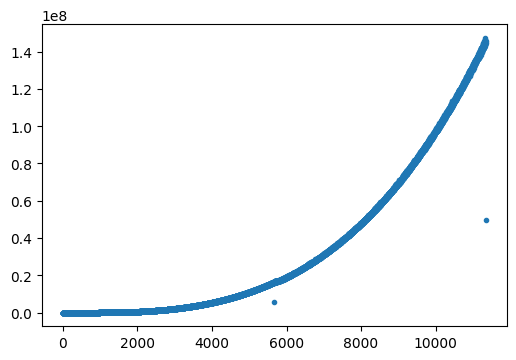

In [124]:
plt.plot(np.arange(len(kls)),kls,".")

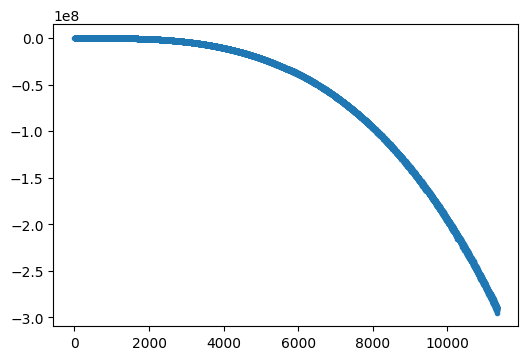

In [125]:
plt.plot(np.arange(len(kls)),BCEs,".")

In [101]:
train_metrics

[array(0.06052384), array(0.06070294)]

## Sampling from the decoder

In [102]:
torch.Size([latent_dims])

torch.Size([5])

In [103]:
sample = vae.encoder.N.sample(torch.Size([100,latent_dims]))

In [104]:
sample = sample.type(torch.float64)

In [105]:
sample

tensor([[ 3.3685e-01,  1.4102e+00, -4.0982e-01, -9.5064e-01,  4.4977e-01],
        [ 1.7844e+00, -1.5096e+00, -2.0072e+00,  3.3275e-01,  1.2407e+00],
        [-1.0050e-01, -3.5910e-01,  1.4990e+00,  1.4078e+00,  8.3376e-01],
        [ 6.3897e-01, -1.9603e+00,  2.9493e+00, -1.0031e+00, -9.6365e-01],
        [ 6.5555e-01,  2.7005e-01, -1.3969e+00, -2.1680e-01, -5.3186e-01],
        [-4.9299e-01, -7.1813e-01,  7.5050e-01, -2.1730e-01,  1.1218e+00],
        [ 8.9278e-01,  2.5350e-01, -1.8939e+00,  1.4744e+00,  5.8610e-01],
        [ 4.6836e-01,  1.7649e-01,  4.3235e-01, -1.6130e+00,  5.8537e-01],
        [ 1.0404e+00,  9.2708e-02, -1.4673e+00, -3.1691e+00,  1.2481e+00],
        [ 1.5063e+00, -5.9082e-01, -9.4162e-01, -9.1349e-02, -6.2733e-01],
        [ 9.0218e-02,  5.5669e-01,  1.1505e-01, -5.7227e-01, -7.1818e-01],
        [-2.4236e+00,  6.0314e-01,  3.9616e-01,  6.1419e-01, -1.1053e+00],
        [ 1.8898e-01, -1.6814e-01,  5.7685e-01, -1.6268e+00, -6.9067e-01],
        [ 1.0550e+00, -1.

In [106]:
ouputs = round_output(vae.decoder(sample))

In [107]:
ouputs.mean(axis=0)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [108]:
np.mean(val_data,axis=0)

array([0.02742323, 0.008443  , 0.01503428, 0.01626877, 0.02208849,
       0.02171373, 0.02420475, 0.07999912, 0.04113485, 0.00555519])